# Step 3 - Final analysis (Python)

This R script will create visualizations for the various outputs produced by R5.  First run "Step 1 - Prepare input data.ipynb", then run "Step 2- Network analysis.ipynb", then this script.

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from shapely.geometry import Polygon, MultiPolygon
import datetime

## Define constants

In [3]:
walk_speed = 2.5 * 1.6  # km/h = mph * 1.6 km/mile
bike_speed = 15 * 1.6  # km/h = mph * 1.6 km/mile

## Load supporting data

Load all of the contextual data that was generated by the previous two scripts.

In [19]:
region = gpd.read_file("./temp_data/region.shp")
region = region.to_crs(epsg=4326)
counties = gpd.read_file("./temp_data/counties.shp")
counties = counties.to_crs(epsg=4326)
tracts = gpd.read_file("./temp_data/tracts.shp")
tracts = tracts.to_crs(epsg=4326)
site = gpd.read_file("./input_data/site/site.shp")
site = site.to_crs(epsg=4326)
park_and_ride = gpd.read_file("./temp_data/park_and_ride.shp")
park_and_ride = park_and_ride.to_crs(epsg=4326)
points = gpd.read_file("./temp_data/points.shp")
points = points.to_crs(epsg=4326)
tract_points = gpd.read_file("./temp_data/tract_points.shp")
tract_points = tract_points.to_crs(epsg=4326)
blocks = gpd.read_file("./temp_data/blocks.shp")
blocks = blocks.to_crs(epsg=4326)
conference_location = gpd.read_file("./temp_data/conference_location.shp")
conference_location = conference_location.to_crs(epsg=4326)

<AxesSubplot:>

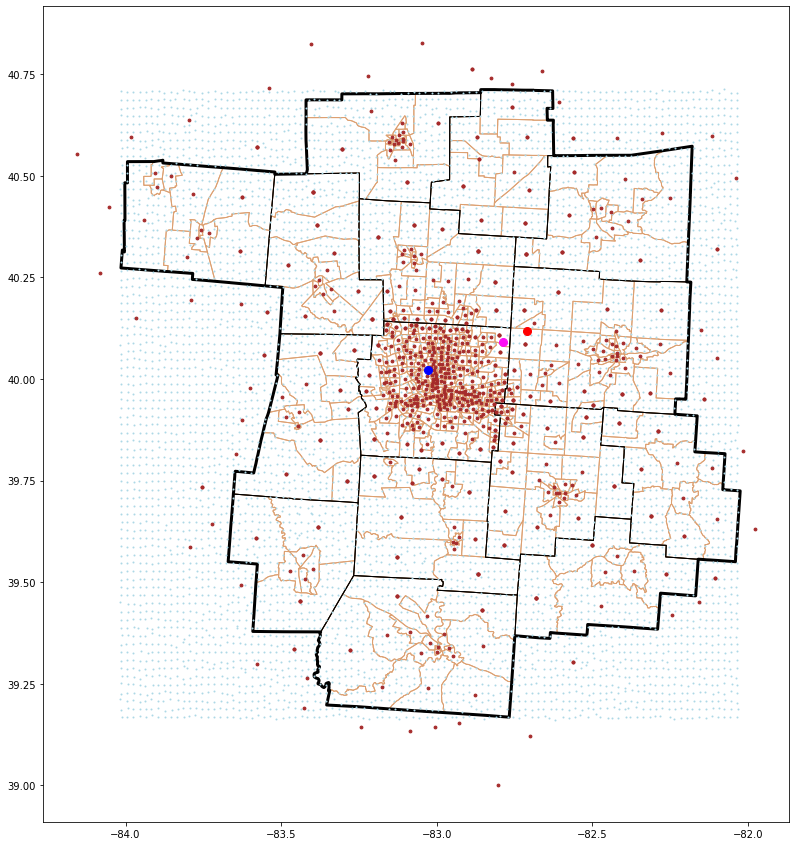

In [21]:
ax = tracts.plot(edgecolor="#dda071", facecolor="none", figsize=(15,15))
counties.plot(ax=ax, edgecolor="black", facecolor="none")
region.plot(ax=ax, linewidth=3, edgecolor="black", facecolor="none")
points.plot(ax=ax, color="lightblue", markersize=1)
tract_points.plot(ax=ax, color="brown", markersize=8)
site.plot(ax=ax, color="red", markersize=64)
park_and_ride.plot(ax=ax, color="#fc0cf4", markersize=64)
conference_location.plot(ax=ax, color="blue", markersize=64)

## Visualize network analysis results

### By transit

In [41]:
ttm = pd.read_csv("./output_data/ttm_TRANSIT_outbound_neighborhoods.csv")
ttm["fromId"] = ttm["fromId"].astype("string")
ttm["toId"] = ttm["toId"].astype("string")
ttm_points = tract_points.copy() \
    .merge(ttm, left_on="id", right_on="toId")

m = counties.explore(tiles="CartoDB positron", style_kwds={"color":"black", "weight":2, "fill":False}, zoom_start=10, location=(conference_location.iloc[0].geometry.y,conference_location.iloc[0].geometry.x))
ttm_points.explore("travel_time", m=m, cmap="viridis", marker_kwds={"radius": 6})
conference_location.explore(m=m, style_kwds={"fillOpacity":1}, marker_kwds={"radius": 4, "color":"blue", "fill":"red"})

### By bike

In [40]:
ttm = pd.read_csv("./output_data/ttm_BIKE_outbound_neighborhoods.csv")
ttm["fromId"] = ttm["fromId"].astype("string")
ttm["toId"] = ttm["toId"].astype("string")
ttm_points = tract_points.copy() \
    .merge(ttm, left_on="id", right_on="toId")

m = counties.explore(tiles="CartoDB positron", style_kwds={"color":"black", "weight":2, "fill":False}, zoom_start=10, location=(conference_location.iloc[0].geometry.y,conference_location.iloc[0].geometry.x))
ttm_points.explore("travel_time", m=m, cmap="viridis", marker_kwds={"radius": 6})
conference_location.explore(m=m, style_kwds={"fillOpacity":1}, marker_kwds={"radius": 4, "color":"blue", "fill":"red"})

## Visualize travel time isochrones

### Car

In [42]:
ttm = pd.read_csv("output_data/ttm_CAR_outbound_90.csv")
ttm["fromId"] = ttm["fromId"].astype("int")
ttm["toId"] = ttm["toId"].astype("int")
ttm_points = points.copy() \
    .merge(ttm, left_on="id", right_on="toId")

In [44]:
GRIDSPACING = 0.005

bounds = region.total_bounds

xmin = bounds[0]
xmax = bounds[2]
ymin = bounds[1]
ymax = bounds[3]

x = np.arange(xmin, xmax, GRIDSPACING)

y = np.arange(ymin, ymax, GRIDSPACING)

X,Y = np.meshgrid(x,y)

coords = np.column_stack((X.ravel(), Y.ravel()))

z = scipy.interpolate.griddata(np.array(list(zip(ttm_points["geometry"].x,ttm_points["geometry"].y))), list(ttm_points["travel_time"]), coords, method="linear")

In [45]:
tightgrid = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_xy(X.ravel(), Y.ravel()))

In [46]:
tightgrid["travel_time"] = z

<AxesSubplot:>

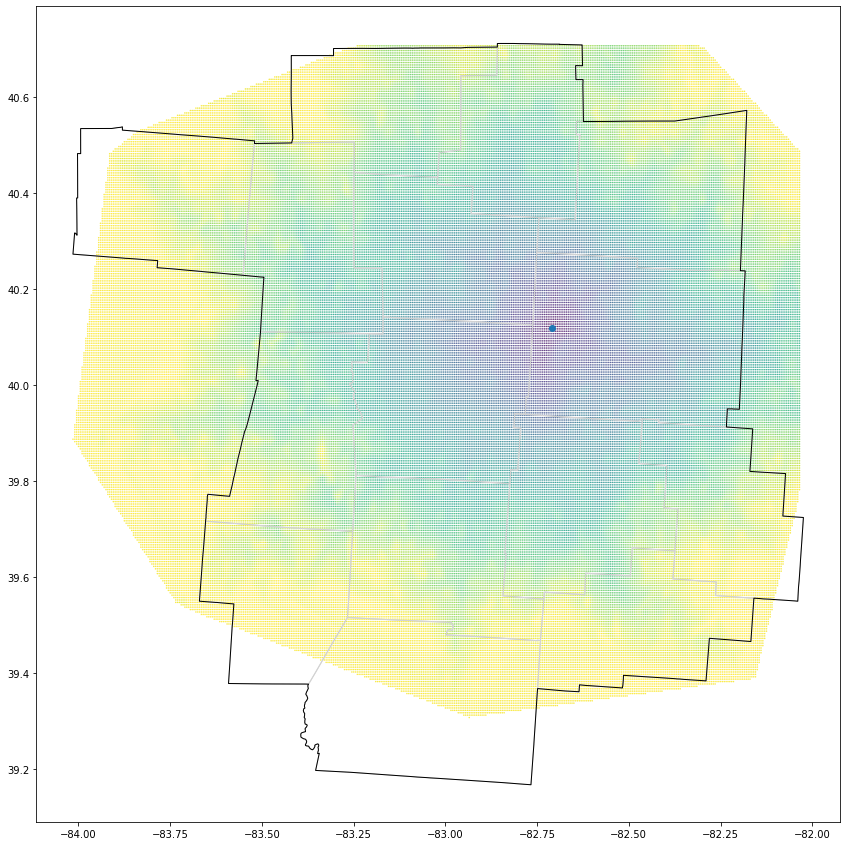

In [47]:
ax = tightgrid.plot(column="travel_time", cmap="viridis", markersize=0.2, figsize=(15,15))
counties.plot(ax=ax, edgecolor="lightgrey", facecolor="none")
region.plot(ax=ax, edgecolor="black", facecolor="none")
site.plot(ax=ax)

In [48]:
Z = z.reshape((len(y),len(x)))

In [49]:
%%capture
levels = [10,20,30,40,50,60,70,80,90]
contourList = []
i = 0
for i in range(0, len(levels)):
    contours = plt.contourf(X,Y,Z, [0, levels[i]])
    thisContourList = []
    collection = contours.collections[0]
    if(len(collection.get_paths()) == 0):
        continue
    for path in collection.get_paths():
        for polygon in path.to_polygons(): 
            thisContourList.append(Polygon(polygon))
    contourList.append({
        "travel_time": levels[i],
        "geometry": MultiPolygon(thisContourList),
    })

# Create the GeoDataFrame
isochrones = gpd.GeoDataFrame.from_records(contourList).sort_values("travel_time", ascending=False)
isochrones.crs = "epsg:4326"
isochrones.to_file("./output_data/isochrones_CAR.shp", index=False)

In [69]:
isochrones

,travel_time,geometry
7,90,"MULTIPOLYGON (((-82.72976 40.09277, -82.72476 ..."
6,80,"MULTIPOLYGON (((-82.72976 40.09317, -82.72863 ..."
5,70,"MULTIPOLYGON (((-82.72976 40.09765, -82.72476 ..."
4,60,"MULTIPOLYGON (((-82.69476 40.10041, -82.68976 ..."
3,50,"MULTIPOLYGON (((-82.68476 40.10727, -82.67976 ..."
2,40,"MULTIPOLYGON (((-82.72476 40.11407, -82.71976 ..."
1,30,"MULTIPOLYGON (((-82.71976 40.11837, -82.71476 ..."
0,20,"MULTIPOLYGON (((-82.71976 40.12224, -82.71476 ..."


In [52]:
m = counties.explore(tiles="CartoDB positron", style_kwds={"color":"black", "weight":2, "fill":False})
isochrones.explore("travel_time", m=m, cmap="viridis")
site.explore(m=m, style_kwds={"fillOpacity":1}, marker_kwds={"radius": 4, "color":"red", "fill":"red"})

### Walk + Bus

In [53]:
ttm = pd.read_csv("output_data/ttm_WALK-TRANSIT-WALK_outbound_90.csv")
ttm["fromId"] = ttm["fromId"].astype("int")
ttm["toId"] = ttm["toId"].astype("int")
ttm_points = points.copy() \
    .merge(ttm, left_on="id", right_on="toId")

In [54]:
GRIDSPACING = 0.005

bounds = region.total_bounds

xmin = bounds[0]
xmax = bounds[2]
ymin = bounds[1]
ymax = bounds[3]

x = np.arange(xmin, xmax, GRIDSPACING)

y = np.arange(ymin, ymax, GRIDSPACING)

X,Y = np.meshgrid(x,y)

coords = np.column_stack((X.ravel(), Y.ravel()))

z = scipy.interpolate.griddata(np.array(list(zip(ttm_points["geometry"].x,ttm_points["geometry"].y))), list(ttm_points["travel_time"]), coords, method="linear")

In [55]:
tightgrid = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_xy(X.ravel(), Y.ravel()))

In [56]:
tightgrid["travel_time"] = z

<AxesSubplot:>

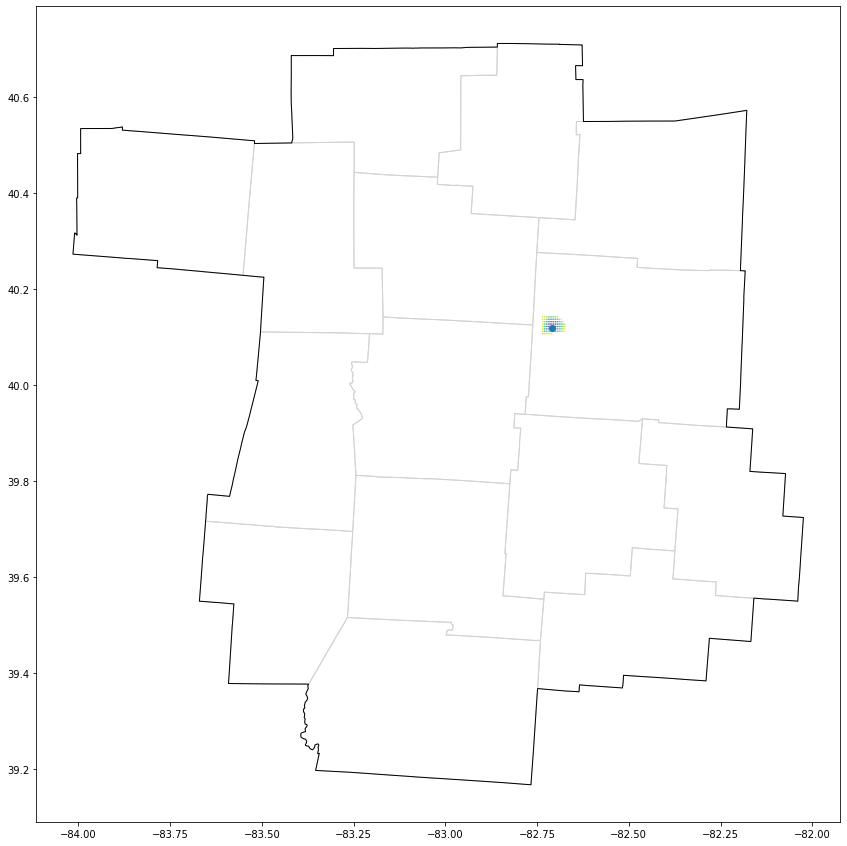

In [57]:
ax = tightgrid.plot(column="travel_time", cmap="viridis", markersize=0.2, figsize=(15,15))
counties.plot(ax=ax, edgecolor="lightgrey", facecolor="none")
region.plot(ax=ax, edgecolor="black", facecolor="none")
site.plot(ax=ax)

In [58]:
Z = z.reshape((len(y),len(x)))

In [59]:
%%capture
levels = [10,20,30,40,50,60,70,80,90]
contourList = []
i = 0
for i in range(0, len(levels)):
    contours = plt.contourf(X,Y,Z, [0, levels[i]])
    thisContourList = []
    collection = contours.collections[0]
    if(len(collection.get_paths()) == 0):
        continue
    for path in collection.get_paths():
        for polygon in path.to_polygons(): 
            thisContourList.append(Polygon(polygon))
    contourList.append({
        "travel_time": levels[i],
        "geometry": MultiPolygon(thisContourList),
    })

# Create the GeoDataFrame
isochrones = gpd.GeoDataFrame.from_records(contourList).sort_values("travel_time", ascending=False)
isochrones.crs = "epsg:4326"
isochrones.to_file("./output_data/isochrones_WALK_BUS.shp", index=False)

In [60]:
isochrones

,travel_time,geometry
6,90,"MULTIPOLYGON (((-82.72976 40.10777, -82.72476 ..."
5,80,"MULTIPOLYGON (((-82.72976 40.10777, -82.72476 ..."
4,70,"MULTIPOLYGON (((-82.72976 40.10892, -82.72476 ..."
3,60,"MULTIPOLYGON (((-82.72976 40.11202, -82.72476 ..."
2,50,"MULTIPOLYGON (((-82.72476 40.11560, -82.71976 ..."
1,40,"MULTIPOLYGON (((-82.71976 40.11905, -82.71476 ..."
0,30,"MULTIPOLYGON (((-82.71976 40.12245, -82.71476 ..."


In [61]:
m = counties.explore(tiles="CartoDB positron", style_kwds={"color":"black", "weight":2, "fill":False})
isochrones.explore("travel_time", m=m, cmap="viridis")
site.explore(m=m, style_kwds={"fillOpacity":1}, marker_kwds={"radius": 4, "color":"red", "fill":"red"})

### Bike + Bus

In [62]:
ttm = pd.read_csv("output_data/ttm_BIKE-TRANSIT-BIKE_outbound_90.csv")
ttm["fromId"] = ttm["fromId"].astype("int")
ttm["toId"] = ttm["toId"].astype("int")
ttm_points = points.copy() \
    .merge(ttm, left_on="id", right_on="toId")

In [63]:
GRIDSPACING = 0.005

bounds = region.total_bounds

xmin = bounds[0]
xmax = bounds[2]
ymin = bounds[1]
ymax = bounds[3]

x = np.arange(xmin, xmax, GRIDSPACING)

y = np.arange(ymin, ymax, GRIDSPACING)

X,Y = np.meshgrid(x,y)

coords = np.column_stack((X.ravel(), Y.ravel()))

z = scipy.interpolate.griddata(np.array(list(zip(ttm_points["geometry"].x,ttm_points["geometry"].y))), list(ttm_points["travel_time"]), coords, method="linear")

In [64]:
tightgrid = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_xy(X.ravel(), Y.ravel()))

In [65]:
tightgrid["travel_time"] = z

<AxesSubplot:>

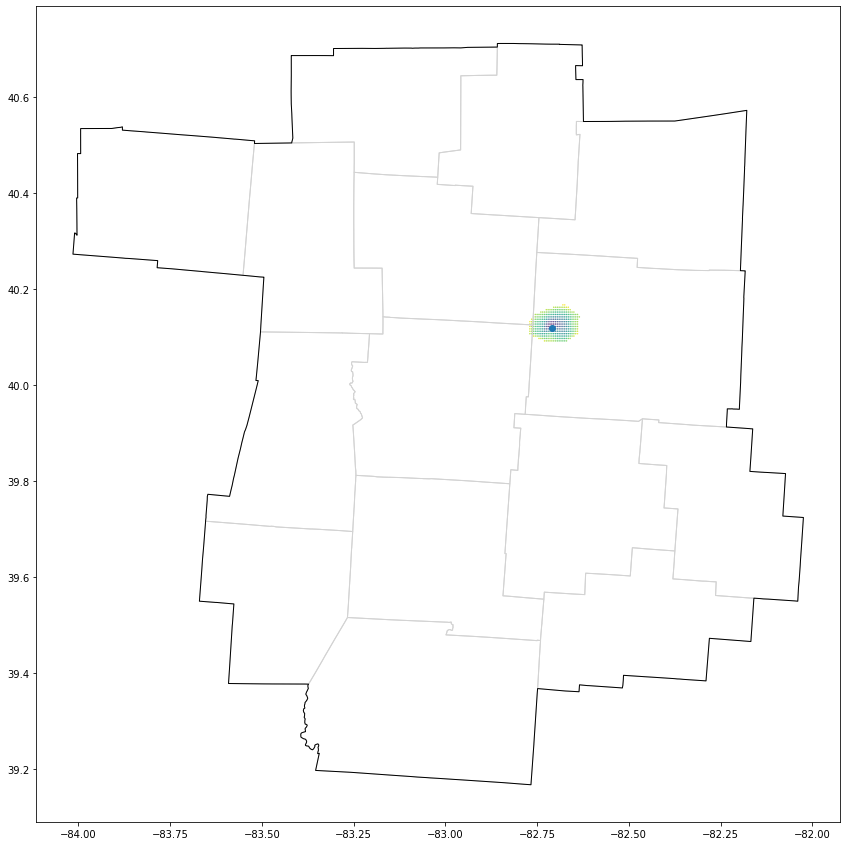

In [66]:
ax = tightgrid.plot(column="travel_time", cmap="viridis", markersize=0.2, figsize=(15,15))
counties.plot(ax=ax, edgecolor="lightgrey", facecolor="none")
region.plot(ax=ax, edgecolor="black", facecolor="none")
site.plot(ax=ax)

In [67]:
Z = z.reshape((len(y),len(x)))

In [68]:
%%capture
levels = [10,20,30,40,50,60,70,80,90]
contourList = []
i = 0
for i in range(0, len(levels)):
    contours = plt.contourf(X,Y,Z, [0, levels[i]])
    thisContourList = []
    collection = contours.collections[0]
    if(len(collection.get_paths()) == 0):
        continue
    for path in collection.get_paths():
        for polygon in path.to_polygons(): 
            thisContourList.append(Polygon(polygon))
    contourList.append({
        "travel_time": levels[i],
        "geometry": MultiPolygon(thisContourList),
    })

# Create the GeoDataFrame
isochrones = gpd.GeoDataFrame.from_records(contourList).sort_values("travel_time", ascending=False)
isochrones.crs = "epsg:4326"
isochrones.to_file("./output_data/isochrones_BIKE_BUS.shp", index=False)

In [69]:
isochrones

,travel_time,geometry
7,90,"MULTIPOLYGON (((-82.72976 40.09277, -82.72476 ..."
6,80,"MULTIPOLYGON (((-82.72976 40.09317, -82.72863 ..."
5,70,"MULTIPOLYGON (((-82.72976 40.09765, -82.72476 ..."
4,60,"MULTIPOLYGON (((-82.69476 40.10041, -82.68976 ..."
3,50,"MULTIPOLYGON (((-82.68476 40.10727, -82.67976 ..."
2,40,"MULTIPOLYGON (((-82.72476 40.11407, -82.71976 ..."
1,30,"MULTIPOLYGON (((-82.71976 40.11837, -82.71476 ..."
0,20,"MULTIPOLYGON (((-82.71976 40.12224, -82.71476 ..."


In [70]:
m = counties.explore(tiles="CartoDB positron", style_kwds={"color":"black", "weight":2, "fill":False})
isochrones.explore("travel_time", m=m, cmap="viridis")
site.explore(m=m, style_kwds={"fillOpacity":1}, marker_kwds={"radius": 4, "color":"red", "fill":"red"})

### Shuttle + Bus

In [71]:
ttm = pd.read_csv("output_data/ttm_SHUTTLE-TRANSIT-WALK_outbound_90.csv")
ttm["fromId"] = ttm["fromId"].astype("int")
ttm["toId"] = ttm["toId"].astype("int")
ttm_points = points.copy() \
    .merge(ttm, left_on="id", right_on="toId")

In [72]:
GRIDSPACING = 0.005

bounds = region.total_bounds

xmin = bounds[0]
xmax = bounds[2]
ymin = bounds[1]
ymax = bounds[3]

x = np.arange(xmin, xmax, GRIDSPACING)

y = np.arange(ymin, ymax, GRIDSPACING)

X,Y = np.meshgrid(x,y)

coords = np.column_stack((X.ravel(), Y.ravel()))

z = scipy.interpolate.griddata(np.array(list(zip(ttm_points["geometry"].x,ttm_points["geometry"].y))), list(ttm_points["travel_time"]), coords, method="linear")

In [73]:
tightgrid = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_xy(X.ravel(), Y.ravel()))

In [74]:
tightgrid["travel_time"] = z

<AxesSubplot:>

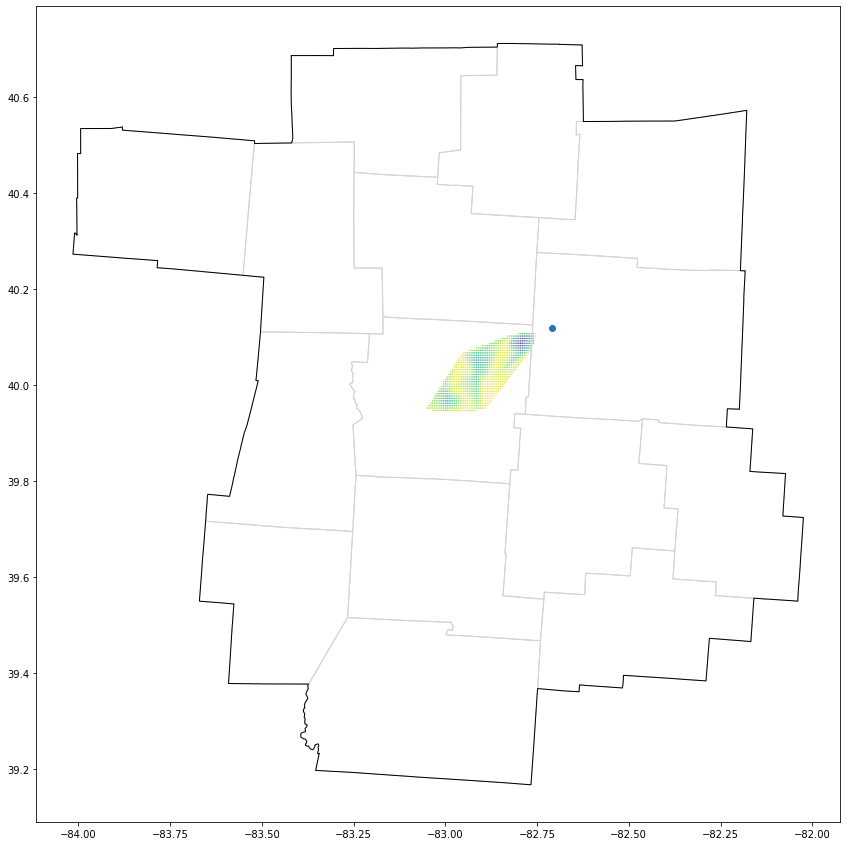

In [75]:
ax = tightgrid.plot(column="travel_time", cmap="viridis", markersize=0.2, figsize=(15,15))
counties.plot(ax=ax, edgecolor="lightgrey", facecolor="none")
region.plot(ax=ax, edgecolor="black", facecolor="none")
site.plot(ax=ax)

In [76]:
Z = z.reshape((len(y),len(x)))

In [77]:
%%capture
levels = [10,20,30,40,50,60,70,80]
contourList = []
i = 0
for i in range(0, len(levels)):
    contours = plt.contourf(X,Y,Z, [0, levels[i]])
    thisContourList = []
    collection = contours.collections[0]
    if(len(collection.get_paths()) == 0):
        continue
    for path in collection.get_paths():
        for polygon in path.to_polygons(): 
            thisContourList.append(Polygon(polygon))
    contourList.append({
        "travel_time": levels[i],
        "geometry": MultiPolygon(thisContourList),
    })

# Create the GeoDataFrame
isochrones = gpd.GeoDataFrame.from_records(contourList).sort_values("travel_time", ascending=False)
isochrones.crs = "epsg:4326"
isochrones.to_file("./output_data/isochrones_SHUTTLE_TRANSIT_WALK.shp", index=False)

In [78]:
isochrones

,travel_time,geometry
6,80,"MULTIPOLYGON (((-83.03476 39.94777, -83.02976 ..."
5,70,"MULTIPOLYGON (((-83.02976 39.95277, -83.02476 ..."
4,60,"MULTIPOLYGON (((-82.99476 39.95439, -82.98976 ..."
3,50,"MULTIPOLYGON (((-82.99976 39.96708, -82.99476 ..."
2,40,"MULTIPOLYGON (((-82.79976 40.07618, -82.79476 ..."
1,30,"MULTIPOLYGON (((-82.79976 40.08190, -82.79476 ..."
0,20,"MULTIPOLYGON (((-82.79476 40.08490, -82.79102 ..."


In [79]:
m = counties.explore(tiles="CartoDB positron", style_kwds={"color":"black", "weight":2, "fill":False})
isochrones.explore("travel_time", m=m, cmap="viridis")
site.explore(m=m, style_kwds={"fillOpacity":1}, marker_kwds={"radius": 4, "color":"red", "fill":"red"})

## Compute accessibility

In [80]:
block_centroids = blocks.to_crs(epsg=3735).copy()
block_centroids["geometry"] = block_centroids["geometry"].centroid
block_centroids["TOTALPOP"] = block_centroids["TOTALPOP"].astype("int")
block_centroids.head()

,GEOID,COUNTYFP,TOTALPOP,geometry
0,390970412003030,097,27,POINT (1751580.610 625132.603)
1,390970412003005,097,94,POINT (1750019.327 627203.438)
2,390970412002014,097,0,POINT (1755442.690 626080.351)
3,390970411004019,097,1,POINT (1717688.092 690977.420)
4,390970413001057,097,1,POINT (1664365.458 642473.125)


In [81]:
isochrones_car = gpd.read_file("./output_data/isochrones_CAR.shp").to_crs(epsg=3735)
isochrones_transit = gpd.read_file("./output_data/isochrones_SHUTTLE_TRANSIT_WALK.shp").to_crs(epsg=3735)
budget_car = isochrones_car.loc[isochrones_car["travel_tim"] == 60]
budget_transit = isochrones_transit.loc[isochrones_transit["travel_tim"] == 80]

<AxesSubplot:>

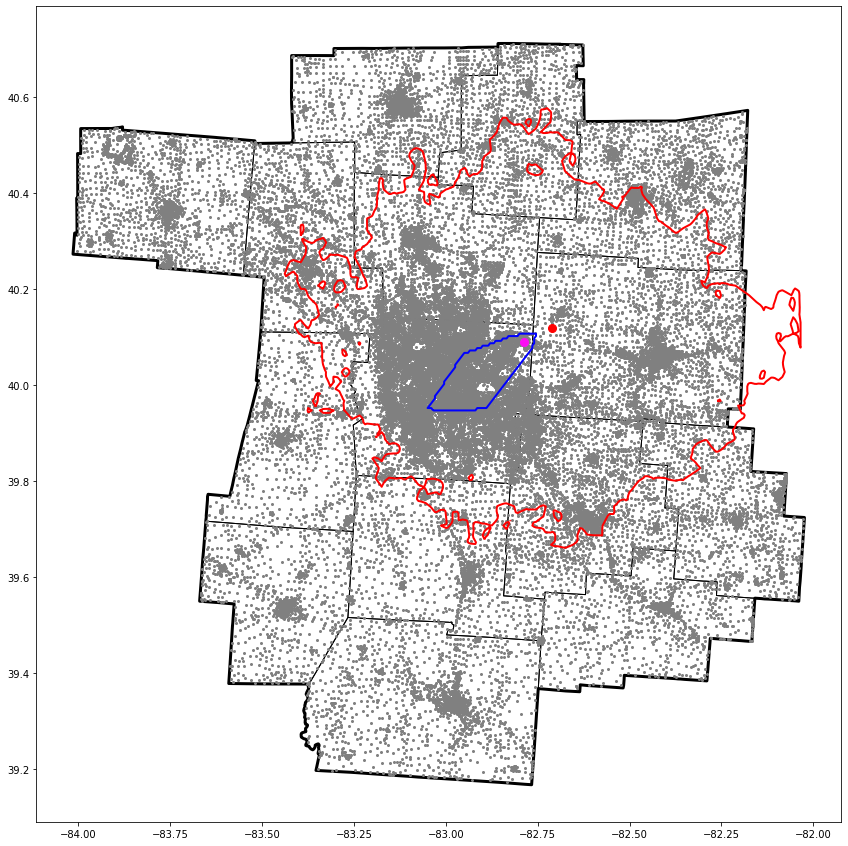

In [82]:
ax = counties.plot(edgecolor="black", facecolor="none", figsize=(15,15))
region.plot(ax=ax, linewidth=3, edgecolor="black", facecolor="none")
block_centroids.to_crs(epsg=4326).plot(ax=ax, color="grey", markersize=4)
site.plot(ax=ax, color="red", markersize=64)
park_and_ride.plot(ax=ax, color="#fc0cf4", markersize=64)
budget_car.to_crs(epsg=4326).plot(ax=ax, edgecolor="red", facecolor="none", linewidth=2, legend=True)
budget_transit.to_crs(epsg=4326).plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=2, legend=True)

In [83]:
opportunities_car = gpd.sjoin(block_centroids, budget_car, how='right', predicate='intersects', lsuffix='left', rsuffix='right')
opportunities_transit = gpd.sjoin(block_centroids, budget_transit, how='right', predicate='intersects', lsuffix='left', rsuffix='right')

In [84]:
opportunities_stats = pd.DataFrame.from_dict({
        "Car": {
            "Population served": opportunities_car["TOTALPOP"].sum(),
            "Area covered (sq. mi.)": budget_car.area.sum()/(5280**2)
        },
        "Transit with shuttle": {
            "Population served": opportunities_transit["TOTALPOP"].sum(),
            "Area covered (sq. mi.)": budget_transit.area.sum()/(5280**2)
        }
    }, 
    orient="index")
opportunities_stats["Population/Area"] = opportunities_stats["Population served"] / opportunities_stats["Area covered (sq. mi.)"]
opportunities_stats.to_csv("./output_data/opportunities_stats.csv")
opportunities_stats

,Population served,Area covered (sq. mi.),Population/Area
Car,1957283,2633.238711,743.298734
Transit with shuttle,301040,89.158237,3376.468744


<AxesSubplot:>

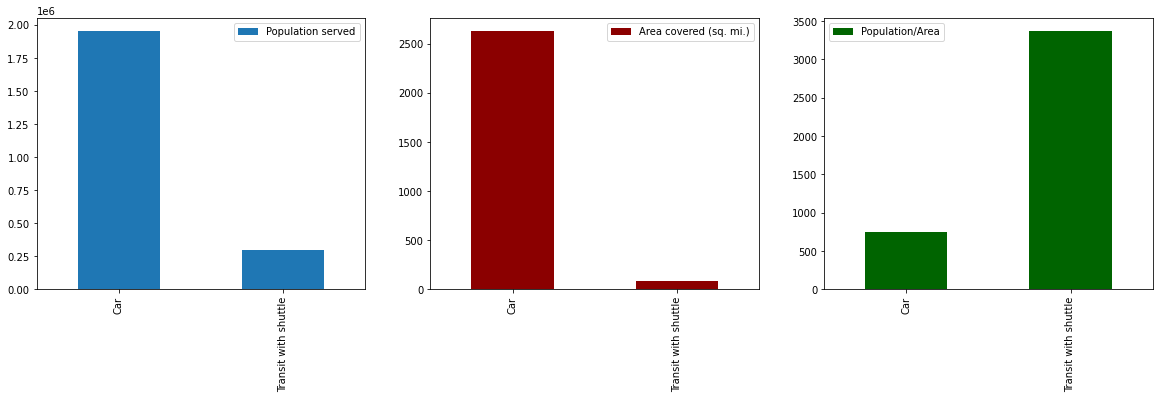

In [85]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
opportunities_stats.plot.bar(ax=ax[0], y="Population served")
opportunities_stats.plot.bar(ax=ax[1], y="Area covered (sq. mi.)", color="darkred")
opportunities_stats.plot.bar(ax=ax[2], y="Population/Area", color="darkgreen")

## Create detailed itineraries

In [97]:
itineraries = gpd.read_file("./output_data/itineraries_ANY_toconference_150.shp")
singleItinerary = itineraries.loc[itineraries["option"] == 3].copy()
singleItinerary["LABEL"] = singleItinerary["segment"].astype("str")  + " / " + singleItinerary["mode"]
print("Trip time (min): {} total, {} travel, {} wait".format(singleItinerary["ttl_drt"].max(), singleItinerary["sgmnt_d"].sum(), singleItinerary["wait"].sum()))
print("Walking distance (meters): {}".format(singleItinerary.loc[singleItinerary["mode"] == "WALK", "distanc"].sum()))
print("Biking distance (meters): {}".format(singleItinerary.loc[singleItinerary["mode"] == "BICYCLE", "distanc"].sum()))
destinationPoint = conference_location.iloc[[0]]
m = singleItinerary.explore(column="LABEL", cmap="rainbow", tiles="CartoDB positron", style_kwds={"weight":8}, legend=True)
site.explore(m=m)
destinationPoint.explore(m=m)

Trip time (min): 90.36666666666666 total, 80.28333333333332 travel, 10.083333333333332 wait
Walking distance (meters): 1016
Biking distance (meters): 0
